In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn import linear_model
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv('../databases/Tcritical.csv', comment='#')
# dataset.shape[0]
dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.000001,NaN,NaN,1184.80,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.007501,NaN,NaN,1153.41,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.015000,NaN,NaN,1126.40,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.022500,NaN,NaN,1102.75,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.030000,NaN,NaN,1081.80,hipo


In [3]:
def fit_polynomial(tcrit, eutectoid, degree, reg=linear_model.LinearRegression()):
    
    if not eutectoid:
        sel = ~np.isnan(dataset[tcrit].values)
        
    else:
        sel = ~np.isnan(dataset[tcrit].values) & (dataset.eutectoid == eutectoid)
    
    filtered_dataset = dataset[sel]
    
    ind_var = filtered_dataset[['C', 'Mn', 'Si', 'Cr', 'Ni']]*100
    
    dep_var = filtered_dataset[tcrit].values
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    ind_var_ = poly.fit_transform(ind_var)

    reg.fit(ind_var_, dep_var)
    
    fitting_summary = {
        'filtered_dataset': filtered_dataset,
        'poly': poly,
        'reg': reg,
        'dep_var': dep_var,
        'ind_var_': ind_var_
    }
    
    return fitting_summary

In [4]:
def rename_ind_var_names(ind_var_names):
    ind_var_names = list(map(lambda x: str.replace(x, 'x0', 'C'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x1', 'Mn'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x2', 'Si'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x3', 'Cr'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x4', 'Ni'), ind_var_names))
    return ind_var_names

In [5]:
def fit_any_function(tcrit, eutectoid, f, reg=linear_model.LinearRegression()):
    
    if not eutectoid:
        sel = ~np.isnan(dataset[tcrit].values)
        
    else:
        sel = ~np.isnan(dataset[tcrit].values) & (dataset.eutectoid == eutectoid)
    
    filtered_dataset = dataset[sel]
    
    ind_var = filtered_dataset[['C', 'Mn', 'Si', 'Cr', 'Ni']]*100
    
    dep_var = filtered_dataset[tcrit].values
    
    poly = FunctionTransformer(f)
    ind_var_ = poly.fit_transform(ind_var)

    reg.fit(ind_var_, dep_var)
    
    fitting_summary = {
        'filtered_dataset': filtered_dataset,
        'poly': poly,
        'reg': reg,
        'dep_var': dep_var,
        'ind_var_': ind_var_
    }
    
    return fitting_summary

In [6]:
def predict_poly(smry, predict, transform=True):
    if transform:
        predict_ = smry['poly'].fit_transform(predict)
    else:
        predict_ = predict
    return smry['reg'].predict(predict_)

In [7]:
def get_coeficients(poly, clf, predict):
    print(poly.get_feature_names())
    
    print(reg.coef_)
    print(reg.intercept_)
    
    predict_ = poly.fit_transform(predict)
    print(reg.predict(predict_))

In [17]:
def plot_fit(smry):
    dep_var, reg, ind_var_ = smry['dep_var'], smry['reg'], smry['ind_var_']
    plt.plot(dep_var, reg.predict(ind_var_), 'kx')
    Tmin, Tmax = np.min(dep_var), np.max(dep_var)
    plt.plot([Tmin, Tmax], [Tmin, Tmax], 'r-')    

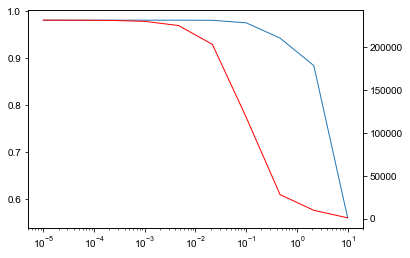

In [49]:
alphalist = 10**np.linspace(-5, 1, 10)
coef2 = []
r2 = []
for alpha in alphalist:
    smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Lasso(alpha=alpha))

    coef2 += [np.sum(np.array(smry['reg'].coef_)**2)]
    r2 += [r2_score(smry['dep_var'], predict_poly(smry, smry['ind_var_'], False))]
    
# plt.legend(loc='right')

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(alphalist, r2)
ax2.plot(alphalist, coef2, color='r')
# ax2.set_yscale('log')
ax.set_xscale('log')

# fig, ax3 = plt.subplots()
# plot_fit(smry)

1196.07128568


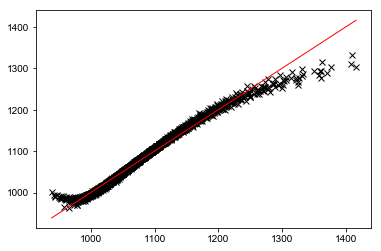

In [137]:
# def f(X):
#     C, Mn, Si, Cr, Ni = X.T
#     X_ = np.vstack([C, C**2, C**2*Mn, C**2*Si, C**2*Cr, C**2*Ni, C*Mn, C*Si, C*Cr, C*Ni, Mn, Mn*Si, Mn*Cr, Mn*Ni, Mn**2, Si, Si*Cr, Si*Ni, Si**2, Cr, Cr*Ni, Cr**2, Ni, Ni**2]).T
#     return X_

# smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Lasso())
# print(smry['reg'].coef_)
# plot_fit(smry)

# smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Ridge(alpha=.01, normalize=True))
smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.LinearRegression())
# smry = fit_any_function('A3', 'hipo', f, reg=linear_model.LinearRegression())
print(smry['reg'].intercept_)
plot_fit(smry)

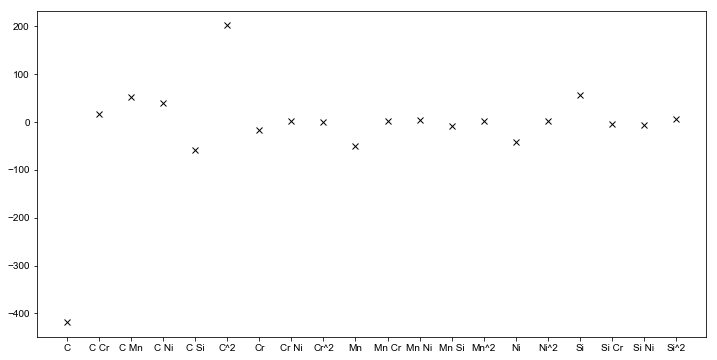

In [138]:
fig, ax = plt.subplots(figsize=(12,6))
ind_var_names = smry['poly'].get_feature_names()
ind_var_names = rename_ind_var_names(ind_var_names)
ax.plot(ind_var_names, smry['reg'].coef_, 'kx')

Int64Index([ 625,  626,  627,  628,  629,  630,  631,  632,  633,  634,
            ...
            3003, 3025, 3026, 3050, 3051, 3075, 3100, 3125, 3150, 3225],
           dtype='int64', length=1642)


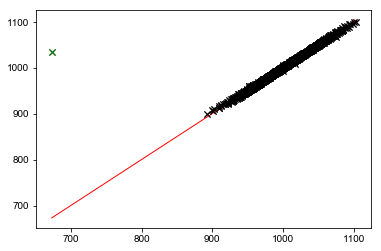

In [25]:
smry = fit_polynomial('A1prime', 'hipo', 2, reg=linear_model.RANSACRegressor())
plot_fit(smry)

filtered_dataset = smry['filtered_dataset']
ransac = smry['reg']
dep_var = smry['dep_var']
ind_var_ = smry['ind_var_']

inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask

# print(len(filtered_dataset.index), len(inlier_mask))
print(filtered_dataset[inlier_mask].index)

plt.plot(dep_var[inlier_mask], ransac.predict(ind_var_)[inlier_mask], 'kx')
plt.plot(dep_var[outlier_mask], ransac.predict(ind_var_)[outlier_mask], 'gx')

In [27]:
filtered_dataset[outlier_mask]

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
3324,../results/03324.DAT,../macros_thermocalc/macro_67.tcm,0.0075,0.007501,0.015,0.03,0.03,NaN,673.0,957.899,hipo
